# 1. Inception块

可以利用Inception块构建经典网络InceptionNet，也就是GoolgeNet

那么，以CIFAR-10 数据集的分类为例，采用GoolgeNet模型来解决问题

# 2. 数据读取

CIFAR-10 数据集的分类是机器学习中一个公开的基准测试问题

其任务是对一组32x32RGB的图像进行分类，这些图像涵盖了10个类别：
飞机， 汽车， 鸟， 猫， 鹿， 狗， 青蛙， 马， 船以及卡车

利用网上的 CIFAR-10 数据集 获取数据集压缩文件，这里使用的是python版本 CIFAR-10 python version

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import urllib.request
import tarfile
import pickle as p
from sklearn.preprocessing import OneHotEncoder

# 下载 cifar10
url = 'https://www.cs.toronto.edu/-kriz/cifar-10-python.tar.gz'
filepath = '../data/cifar-10-python.tar.gz'
if not os.path.isfile(filepath):
    result = urllib.request.urlretrieve(url, filepath)
    print('downloaded', result)
else:
    print('Data file already exists.')

# 解压 cifar10
if not os.path.exists("../data/cifar-10-batches-py"):
    tfile = tarfile.open("../data/cifar-10-python.tar.gz", 'r:gz')
    result = tfile.extractall("../data/")
    print('Extracted to ./../data/cifar-10-batches-py/')
else:
    print('Directory already exists.')

Data file already exists.
Directory already exists.


加载数据集

In [2]:
def load_CIFAR_batch(filename):
    """oad single batch of cifar"""
    with open(filename, 'rb')as f:
        # 一个样本由标签和图像数据组成
        # <1 xlabel><3072 xpixel> (3072-32x32x3)
        data_dict = p.load(f, encoding='bytes')
        images = data_dict[b'data']
        labels = data_dict[b'labels']
        # 把原始数据结构调整为: BCWH
        images = images.reshape(10000, 3, 32, 32)
        # tensorflow处理图像数据的结构: BWHC
        # #把通道数据C移动到最后一个维度
        images = images.transpose(0, 2, 3, 1)
        labels = np.array(labels)
        return images, labels


def load_CIFAR_data(data_dir):
    """load CIFAR data"""
    images_train = []
    labels_train = []
    for i in range(5):
        f = os.path.join(data_dir, 'data_batch_{0}'.format(i + 1))
        print('loading', f)
        # 调用loadCIFARbatch(获得批量的图像及其对应的标签
        image_batch, label_batch = load_CIFAR_batch(f)
        images_train.append(image_batch)
        labels_train.append(label_batch)
        Xtrain = np.concatenate(images_train)
        Ytrain = np.concatenate(labels_train)
        del image_batch, label_batch
    Xtest, Ytest = load_CIFAR_batch(os.path.join(data_dir, 'test_batch'))
    print('finished loadding CIFAR-10 data')
    # 返回训练集的图象和标签，测试集的图像和标签
    return Xtrain, Ytrain, Xtest, Ytest


data_dir = '../data/cifar-10-batches-py/'
Xtrain, Ytrain, Xtest, Ytest = load_CIFAR_data(data_dir)

loading ../data/cifar-10-batches-py/data_batch_1
loading ../data/cifar-10-batches-py/data_batch_2
loading ../data/cifar-10-batches-py/data_batch_3
loading ../data/cifar-10-batches-py/data_batch_4
loading ../data/cifar-10-batches-py/data_batch_5
finished loadding CIFAR-10 data


查看数据集数量

In [3]:
print('training data shape:', Xtrain.shape)
print('training labels shape:', Ytrain.shape)
print('test data shape:', Xtest.shape)
print('test labels shape:', Ytest.shape)

training data shape: (50000, 32, 32, 3)
training labels shape: (50000,)
test data shape: (10000, 32, 32, 3)
test labels shape: (10000,)


定义标签字典

In [4]:
label_dict = {0: "airplane", 1: "automobile", 2: "bird", 3: "cat", 4: "deer",
              5: "dog", 6: "frog", 7: "horse", 8: "ship", 9: "truck"}

查看第11张图片并查看对应的label，虽然模模糊糊，但还可以猜出来是十个类别中的鹿

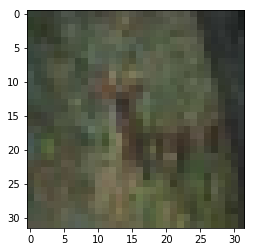

Xtrain[10] label: deer


In [5]:
imshow_num = 10
plt.imshow(Xtrain[imshow_num])
plt.show()
print("Xtrain[{0}] label:".format(imshow_num), label_dict[Ytrain[imshow_num]])

图片进行数字标准化并对比数据

In [6]:
Xtrain_mean0 = np.mean(Xtrain.astype('float32')[:, :, :, 0])
Xtrain_mean1 = np.mean(Xtrain.astype('float32')[:, :, :, 1])
Xtrain_mean2 = np.mean(Xtrain.astype('float32')[:, :, :, 2])
Xtrain_mean = [Xtrain_mean0, Xtrain_mean1, Xtrain_mean2]

Xtrain_std0 = np.std(Xtrain.astype('float32')[:, :, :, 0])
Xtrain_std1 = np.std(Xtrain.astype('float32')[:, :, :, 1])
Xtrain_std2 = np.std(Xtrain.astype('float32')[:, :, :, 2])
Xtrain_std = [Xtrain_std0, Xtrain_std1, Xtrain_std2]


def data_norm(x, x_mean, x_std):
    x_norm = x.astype('float32')
    x_norm[:, :, :, 0] = (x_norm[:, :, :, 0] - x_mean[0]) / x_std[0]
    x_norm[:, :, :, 1] = (x_norm[:, :, :, 1] - x_mean[1]) / x_std[1]
    x_norm[:, :, :, 2] = (x_norm[:, :, :, 2] - x_mean[2]) / x_std[2]
    return x_norm


Xtrain_norm = data_norm(Xtrain, Xtrain_mean, Xtrain_std)
Xtest_norm = data_norm(Xtest, Xtrain_mean, Xtrain_std)

# 对比图像数据
print("Xtrain[0][0][0] data:", Xtrain[0][0][0])
print("Xtrain_norm[0][0][0] data:", Xtrain_norm[0][0][0])

Xtrain[0][0][0] data: [59 62 63]
Xtrain_norm[0][0][0] data: [-1.0526042 -0.9816644 -0.7625441]


标签数据处理并对比数据

In [7]:
encoder = OneHotEncoder(sparse=False, categories='auto')
yy = [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9]]
encoder.fit(yy)
Ytrain_reshape = Ytrain.reshape(-1, 1)
Ytrain_onehot = encoder.transform(Ytrain_reshape)
Ytest_reshape = Ytest.reshape(-1, 1)
Ytest_onehot = encoder.transform(Ytest_reshape)

print("Ytrain[10] data:", Ytrain[10])
print("Ytrain_onehot[10] data:", Ytrain_onehot[10])

Ytrain[10] data: 4
Ytrain_onehot[10] data: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


# 3.构建模型

In [8]:
# 定义训练数据的占位符， x是32*32*3个像素点的特征值， y是10分类的标签值
x = tf.placeholder(tf.float32, [None, 32, 32, 3], name="X")
y = tf.placeholder(tf.float32, [None, 10], name="Y")

# 为了使用卷积层，需把x变成一个4d向量，其第2、第3维对应图片的宽、高，最后一维代表图片的颜色通道数
x_image = tf.reshape(x, [-1, 32, 32, 3])


# 权重W 初始化 从标准差0.1的截断正态分布中输出随机值
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)


# 权重b 初始化 0.1
def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)


# 定义1步长的 same卷积
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')


# 定义1步长的 valid卷积
def conv2d_v(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='VALID')


# 定义2步长的 same卷积
def conv2d_2(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 2, 2, 1], padding='SAME')


# 定义步长为1 大小3x3的 max pooling
def max_pool_3x3(x):
    return tf.nn.max_pool(x, ksize=[1, 3, 3, 1], strides=[1, 1, 1, 1], padding='SAME')


# 定义步长为2 大小3x3的 max pooling
def max_pool_3x3_2(x):
    return tf.nn.max_pool(x, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME')


# 定义步长为3 大小5x5的 avg pooling
def avg_pool_5x5(x):
    return tf.nn.avg_pool(x, ksize=[1, 5, 5, 1], strides=[1, 3, 3, 1], padding='VALID')


# 定义步长为1 大小7x7的 avg pooling
def avg_pool_7x7(x):
    return tf.nn.avg_pool(x, ksize=[1, 7, 7, 1], strides=[1, 1, 1, 1], padding='VALID')


def inception(x, channel_in, filters_num):
    # 第一分支 conv 1x1+1s
    with tf.variable_scope("branch1"):
        branch1_w_conv1 = weight_variable([1, 1, channel_in, filters_num[0]])
        branch1_b_conv1 = bias_variable([filters_num[0]])
        branch1_h_conv1 = tf.nn.relu(conv2d(x, branch1_w_conv1) + branch1_b_conv1)
    # 第二分支 conv 1x1+1s > conv 3x3+1s
    with tf.variable_scope("branch2"):
        branch2_w_conv1 = weight_variable([1, 1, channel_in, filters_num[1]])
        branch2_b_conv1 = bias_variable([filters_num[1]])
        branch2_h_conv1 = tf.nn.relu(conv2d(x, branch2_w_conv1) + branch2_b_conv1)
        branch2_w_conv2 = weight_variable([3, 3, filters_num[1], filters_num[2]])
        branch2_b_conv2 = bias_variable([filters_num[2]])
        branch2_h_conv2 = tf.nn.relu(conv2d(branch2_h_conv1, branch2_w_conv2) + branch2_b_conv2)
    # 第三分支 conv 1x1+1s > conv 5x5+1s
    with tf.variable_scope("branch3"):
        branch3_w_conv1 = weight_variable([1, 1, channel_in, filters_num[3]])
        branch3_b_conv1 = bias_variable([filters_num[3]])
        branch3_h_conv1 = tf.nn.relu(conv2d(x, branch3_w_conv1) + branch3_b_conv1)
        branch3_w_conv2 = weight_variable([5, 5, filters_num[3], filters_num[4]])
        branch3_b_conv2 = bias_variable([filters_num[4]])
        branch3_h_conv2 = tf.nn.relu(conv2d(branch3_h_conv1, branch3_w_conv2) + branch3_b_conv2)
    # 第四分支 max_pool 3x3+1s > conv 1x1+1s
    with tf.variable_scope("branch4"):
        branch4_pool1 = max_pool_3x3(x)
        branch4_w_conv1 = weight_variable([1, 1, channel_in, filters_num[5]])
        branch4_b_conv1 = bias_variable([filters_num[5]])
        branch4_h_conv1 = tf.nn.relu(conv2d(branch4_pool1, branch4_w_conv1) + branch4_b_conv1)
    # 输出叠加
    with tf.variable_scope("depth_concat"):
        concat = tf.concat([branch1_h_conv1, branch2_h_conv2, branch3_h_conv2, branch4_h_conv1], axis=3)
    return concat


# 第一层 conv 7x7+2s 64 > max_pool 3x3+2s > lrn
# w_conv1 = weight_variable([7, 7, 3, 64])
# b_conv1 = bias_variable([64])
# h_conv1 = tf.nn.relu(conv2d_2(x_image, w_conv1) + b_conv1)
# h_pool1 = max_pool_3x3_2(h_conv1)
# hh_lrn1 = tf.nn.lrn(h_pool1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75)

# 第二层 conv 1x1+1s 64 > conv 3x3+1s 192 > lrn > max_pool 3x3+2s
# w_conv2 = weight_variable([1, 1, 64, 64])
# b_conv2 = bias_variable([64])
# h_conv2 = tf.nn.relu(conv2d(hh_lrn1, w_conv2) + b_conv2)
# w_conv3 = weight_variable([3, 3, 64, 192])
# b_conv3 = bias_variable([192])
# h_conv3 = tf.nn.relu(conv2d(h_conv2, w_conv3) + b_conv3)
# h_lrn2 = tf.nn.lrn(h_conv3, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75)
# h_pool2 = max_pool_3x3_2(h_lrn2)

# cifar10图片尺寸较小，为配合后续的计算，调整一些原有结构压缩成28x28x192
# 第一层
w_conv1 = weight_variable([3, 3, 3, 64])
b_conv1 = bias_variable([64])
h_conv1 = tf.nn.relu(conv2d_v(x_image, w_conv1) + b_conv1)
h_pool1 = max_pool_3x3(h_conv1)
hh_lrn1 = tf.nn.lrn(h_pool1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75)
# 第二层
w_conv2 = weight_variable([1, 1, 64, 64])
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(hh_lrn1, w_conv2) + b_conv2)
w_conv3 = weight_variable([3, 3, 64, 192])
b_conv3 = bias_variable([192])
h_conv3 = tf.nn.relu(conv2d_v(h_conv2, w_conv3) + b_conv3)
h_lrn2 = tf.nn.lrn(h_conv3, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75)
h_pool2 = max_pool_3x3(h_lrn2)

# 第三层
# inception 3a
filters_num_3a = [64, 96, 128, 16, 32, 32]  # 设置inception 3a的通道数
inception_3a = inception(h_pool2, 192, filters_num_3a)

# inception 3b
filters_num_3b = [128, 128, 192, 32, 96, 64]
inception_3b = inception(inception_3a, 256, filters_num_3b)

h_pool3 = max_pool_3x3_2(inception_3b)

# 第四层                                 >
# inception 4a
filters_num_4a = [192, 96, 208, 16, 48, 64]
inception_4a = inception(h_pool3, 480, filters_num_4a)
# inception 4b
filters_num_4b = [160, 112, 224, 24, 64, 64]
inception_4b = inception(inception_4a, 512, filters_num_4b)
# softmax0
h_pool4 = avg_pool_5x5(inception_4a)
# > conv 1x1 128
w_conv4 = weight_variable([1, 1, 512, 128])
b_conv4 = bias_variable([128])
h_conv4 = tf.nn.relu(conv2d(h_pool4, w_conv4) + b_conv4)
h_flat1 = tf.reshape(h_conv4, shape=[-1, 4 * 4 * 128])  # 重新展开
# > fc 1x1 1024
W_fc1 = weight_variable([4 * 4 * 128, 1024])
b_fc1 = bias_variable([1024])
h_fc1 = tf.nn.relu(tf.matmul(h_flat1, W_fc1) + b_fc1)
# > fc 1x1 10
dropout_rate0 = tf.placeholder("float")
h_fc1_drop = tf.nn.dropout(h_fc1, rate=dropout_rate0)
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])
h_fc2 = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
# > softmax0
pred0 = tf.nn.softmax(h_fc2)
# inception 4c
filters_num_4c = [128, 128, 256, 24, 64, 64]
inception_4c = inception(inception_4b, 512, filters_num_4c)
# inception 4d
filters_num_4d = [112, 144, 288, 32, 64, 64]
inception_4d = inception(inception_4c, 512, filters_num_4d)
# inception 4e
filters_num_4e = [256, 160, 320, 32, 128, 128]
inception_4e = inception(inception_4d, 528, filters_num_4e)
h_pool5 = max_pool_3x3_2(inception_4e)
# softmax1
h_pool6 = avg_pool_5x5(inception_4d)
# > conv 1x1 128
w_conv5 = weight_variable([1, 1, 528, 128])
b_conv5 = bias_variable([128])
h_conv5 = tf.nn.relu(conv2d(h_pool6, w_conv5) + b_conv5)
h_flat2 = tf.reshape(h_conv5, shape=[-1, 4 * 4 * 128])  # 重新展开
# > fc 1x1 1024
W_fc3 = weight_variable([4 * 4 * 128, 1024])
b_fc3 = bias_variable([1024])
h_fc3 = tf.nn.relu(tf.matmul(h_flat2, W_fc3) + b_fc3)
# > fc 1x1 10
dropout_rate1 = tf.placeholder("float")
h_fc3_drop = tf.nn.dropout(h_fc1, rate=dropout_rate1)
W_fc4 = weight_variable([1024, 10])
b_fc4 = bias_variable([10])
h_fc4 = tf.matmul(h_fc3_drop, W_fc4) + b_fc4
# > softmax1
pred1 = tf.nn.softmax(h_fc4)

# 第五层
# inception 5a
filters_num_5a = [256, 160, 320, 32, 128, 128]
inception_5a = inception(h_pool5, 832, filters_num_5a)
# inception 5b
filters_num_5b = [384, 192, 384, 48, 128, 128]
inception_5b = inception(inception_5a, 832, filters_num_5b)

# avg_pool_7x7
h_pool7 = avg_pool_7x7(inception_5b)
h_flat3 = tf.reshape(h_pool7, shape=[-1, 1 * 1 * 1024])  # 重新展开

# softmax2
dropout_rate2 = tf.placeholder("float")
h_pool7_drop = tf.nn.dropout(h_flat3, rate=dropout_rate2)
W_fc5 = weight_variable([1024, 10])
b_fc5 = bias_variable([10])
h_fc5 = tf.matmul(h_pool7_drop, W_fc5) + b_fc2
pred2 = tf.nn.softmax(h_fc5)

# 整合softmax
forward = h_fc5 + h_fc4 * 0.3 + h_fc2 * 0.3
pred = pred2 + pred1 * 0.3 + pred0 * 0.3

# 定义损失函数
with tf.name_scope("LossFunction"):
    loss_function = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=forward, labels=y))

# 4.训练模型

In [9]:
train_epochs = 0  # 迭代次数 20
learning_rate = 0.0001  # 学习率

# Adam优化器 设置学习率和优化目标损失最小化
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss_function)

# 定义预测类别匹配情况
correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))

# 定义准确率，将布尔值转化成浮点数，再求平均值
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

# 每个批次的大小，每次放入的大小，每次放入 128张图片 以矩阵的方式
batch_size = 128

# 计算一共有多少个批次，数量整除大小训练出有多少批次
n_batch = len(Ytrain_onehot) // batch_size // 10 * 10

# 定义显示训练过程中验证的间隔批量次数
display_test_num = n_batch // 10

# 定义显示训练过程.的间隔批量次数
display_train_num = display_test_num // 10

# 定义保存模型
saver = tf.train.Saver()
save_dir = "../save_path/GoogleNet/"

# 定义保存模型编号
save_step = 0

# 恢复保存模型
ckpt_dir = tf.train.latest_checkpoint(save_dir)
sess = tf.Session()  # 建立会话
if ckpt_dir != None:
    saver.restore(sess, ckpt_dir)
    print("Finished loading", ckpt_dir)
    save_step = int(input("Set the load save step:"))
else:
    # 变量初始化
    sess.run(tf.initialize_all_variables())
    print("Finished initialize")

# 定义批次训练数据的占位符
x_batch = tf.placeholder(tf.float32, [None, 32, 32, 3], name="X_batch")
# 随机上下翻转批次图片
Xtrain_batch_up = tf.image.random_flip_up_down(x_batch)
# 随机左右翻转批次图片
Xtrain_batch_lf = tf.image.random_flip_left_right(Xtrain_batch_up)


# 对角旋转批次图片
# Xtrain_batch_tp = tf.image.transpose_image(x_batch)


# 定义训练集批次函数
def get_train_batch(num, size):
    Xtrain_batch = Xtrain_norm_shuffle[num * size:(num + 1) * size]
    Ytrain_batch = Ytrain_onehot_shuffle[num * size:(num + 1) * size]
    # 随机翻转数据
    with tf.Session() as sess_batch:
        Xtrain_batch = sess_batch.run(Xtrain_batch_lf, feed_dict={x_batch: Xtrain_batch})
        return Xtrain_batch, Ytrain_batch


# 迭代训练
for epoch in range(train_epochs):
    # 打乱训练数据集
    index = [i for i in range(len(Ytrain_onehot))]
    random.shuffle(index)
    Xtrain_norm_shuffle = Xtrain_norm[index]
    Ytrain_onehot_shuffle = Ytrain_onehot[index]

    # 批次迭代训练
    for batch in range(0, n_batch):
        xs, ys = get_train_batch(batch, batch_size)
        sess.run(optimizer, feed_dict={x: xs, y: ys, dropout_rate0: 0.4, dropout_rate1: 0.4, dropout_rate2: 0.4})

        if (batch + 1) % display_train_num == 0:
            print(".", end="")

        if (batch + 1) % display_test_num == 0:
            # 保存模型
            save_step += 1
            save_path = saver.save(sess, save_dir + "model", global_step=save_step)
            print("Complete save ", save_path)
            # 批次训练完成之后，使用验证数据计算误差与准确率
            loss, acc = sess.run([loss_function, accuracy], feed_dict={x: xs,
                                                                       y: ys,
                                                                       dropout_rate0: 0,
                                                                       dropout_rate1: 0,
                                                                       dropout_rate2: 0})
            # 显示训练信息
            print("TrainEpoch=", '%02d' % (epoch + 1), "TrainBatch=", '%04d' % (batch + 1),
                  "Loss=", '{:.9f}'.format(loss), "TrainAccuracy=", "{:.4f}".format(acc))

    learning_rate = 0.9 * learning_rate  # 学习率衰减

W0809 10:16:22.000710  6140 deprecation.py:323] From C:\Users\DELL\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\training\saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


Finished loading D:/save_path/GoogleNet/model-200
Set the load save step:200


# 5.评估模型

In [10]:
test_total_batch = int(len(Xtest_norm) / batch_size)
test_acc_sum = 0.0
for i in range(test_total_batch):
    test_image_batch = Xtest_norm[i * batch_size:(i + 1) * batch_size]
    test_label_batch = Ytest_onehot[i * batch_size:(i + 1) * batch_size]
    test_batch_acc = sess.run(accuracy, feed_dict={x: test_image_batch,
                                                   y: test_label_batch,
                                                   dropout_rate0: 0,
                                                   dropout_rate1: 0,
                                                   dropout_rate2: 0})
    test_acc_sum += test_batch_acc
test_acc = float(test_acc_sum / test_total_batch)
print("Test accuracy:{:.6f}".format(test_acc))

Test accuracy:0.807292


# 6. 模型预测

查看预测结果

In [11]:
# 转换第201-210张测试图片pred预测结果独热编码格式为数字0-9
prediction_result = sess.run(tf.argmax(pred, 1), feed_dict={x: Xtest_norm[200:210],
                                                            dropout_rate0: 0,
                                                            dropout_rate1: 0,
                                                            dropout_rate2: 0})

# 查看第201-210张测试图片的预测结果
print(prediction_result)

[5 1 8 7 1 3 0 5 7 9]


预测结果可视化比对

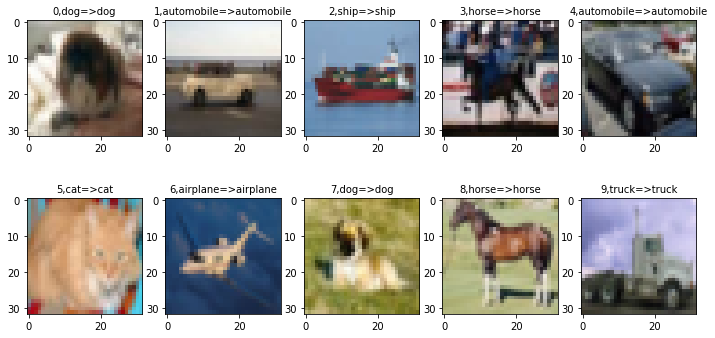

In [12]:
# 定义显示图缘数据及其对应标签的函数
def plot_images_labels_prediction(images, labels, prediction, idx, num=10):
    fig = plt.gcf()
    fig.set_size_inches(12, 6)
    if num > 10:
        num = 10
    for i in range(0, num):
        ax = plt.subplot(2, 5, 1 + i)
        ax.imshow(images[idx], cmap="binary")
        title = str(i) + ',' + label_dict[labels[idx]]
        if len(prediction) > 0:
            title += '=>' + label_dict[prediction[i]]
        ax.set_title(title, fontsize=10)
        idx += 1
    plt.show()


# 验证第201-210张测试图片的预测结果
plot_images_labels_prediction(Xtest, Ytest, prediction_result, 200, 10)